<a href="https://colab.research.google.com/github/bavya-sri/Rasmalai/blob/Final/DNCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.layers import Input,MaxPool2D,Conv2D,UpSampling2D,Activation,BatchNormalization,Subtract
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
import datetime
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_files=['/content/drive/MyDrive/DataScience/patches-train/train/'+filename for filename in os.listdir('/content/drive/MyDrive/DataScience/patches-train/train/')]
test_files=['/content/drive/MyDrive/DataScience/patches-test/test/'+filename for filename in os.listdir('/content/drive/MyDrive/DataScience/patches-test/test/')]

In [4]:
def _parse_function(filename):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)/255.

    noise_level=np.random.choice(NOISE_LEVELS)
    noisy_image=image+tf.random.normal(shape=(40,40,3),mean=0,stddev=noise_level/255)
    noisy_image=tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)

    return noisy_image,image

In [5]:
BATCH_SIZE=64
NOISE_LEVELS=[15,25,50] 

#Creating the Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(np.array(train_files)) 
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices(np.array(test_files))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [6]:
iterator = iter(train_dataset)
a, b = iterator.get_next()

print('Shape of single batch of x : ',a.shape)
print('Shape of single batch of y : ',b.shape)

Shape of single batch of x :  (64, 40, 40, 3)
Shape of single batch of y :  (64, 40, 40, 3)


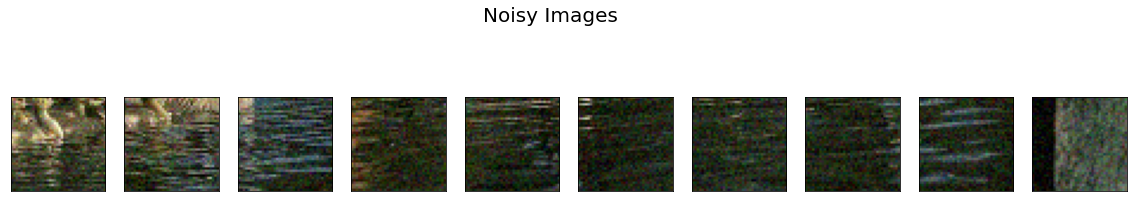

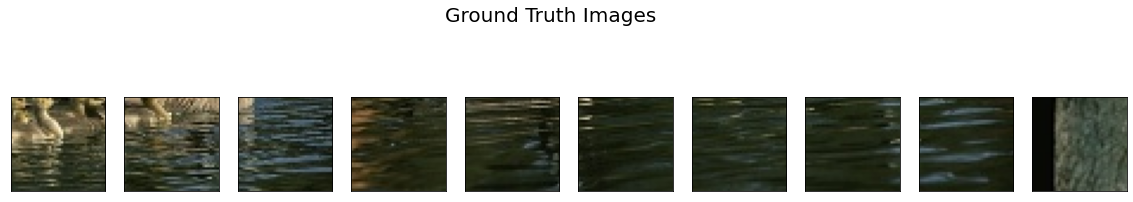

In [7]:
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(a[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Noisy Images',fontsize=20)
plt.show()
fig, axs = plt.subplots(1,10,figsize=(20,4))
for i in range(10):
  axs[i].imshow(b[i])
  axs[i].get_xaxis().set_visible(False)
  axs[i].get_yaxis().set_visible(False)
fig.suptitle('Ground Truth Images',fontsize=20)
plt.show()

In [8]:
def get_patches(file_name,patch_size,crop_sizes):
    image = cv2.imread(file_name) 
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    height, width , channels= image.shape
    patches = []
    for crop_size in crop_sizes: 
        crop_h, crop_w = int(height*crop_size),int(width*crop_size)
        image_scaled = cv2.resize(image, (crop_w,crop_h), interpolation=cv2.INTER_CUBIC)
        for i in range(0, crop_h-patch_size+1, patch_size):
            for j in range(0, crop_w-patch_size+1, patch_size):
              x = image_scaled[i:i+patch_size, j:j+patch_size] 
              patches.append(x)
    return patches

def create_image_from_patches(patches,image_shape):
  image=np.zeros(image_shape) 
  patch_size=patches.shape[1]
  p=0
  for i in range(0,image.shape[0]-patch_size+1,patch_size):
    for j in range(0,image.shape[1]-patch_size+1,patch_size):
      image[i:i+patch_size,j:j+patch_size]=patches[p] 
      p+=1
  return np.array(image)

def predict_fun(model,image_path,noise_level=30):
  patches=get_patches(image_path,40,[1])
  test_image=cv2.imread(image_path)

  patches=np.array(patches)
  ground_truth=create_image_from_patches(patches,test_image.shape)

  patches = patches.astype('float32') /255.
  patches_noisy = patches+ tf.random.normal(shape=patches.shape,mean=0,stddev=noise_level/255) 
  patches_noisy = tf.clip_by_value(patches_noisy, clip_value_min=0., clip_value_max=1.)
  noisy_image=create_image_from_patches(patches_noisy,test_image.shape)

  denoised_patches=model.predict(patches_noisy)
  denoised_patches=tf.clip_by_value(denoised_patches, clip_value_min=0., clip_value_max=1.)

  denoised_image=create_image_from_patches(denoised_patches,test_image.shape)

  return patches_noisy,denoised_patches,ground_truth/255.,noisy_image,denoised_image


def plot_patches(patches_noisy,denoised_patches):
  fig, axs = plt.subplots(2,10,figsize=(20,4))
  for i in range(10):

    axs[0,i].imshow(patches_noisy[i])
    axs[0,i].title.set_text(' Noisy')
    axs[0,i].get_xaxis().set_visible(False)
    axs[0,i].get_yaxis().set_visible(False)

    axs[1,i].imshow(denoised_patches[i])
    axs[1,i].title.set_text('Denoised')
    axs[1,i].get_xaxis().set_visible(False)
    axs[1,i].get_yaxis().set_visible(False)
  plt.show()

def plot_predictions(ground_truth,noisy_image,denoised_image):
  fig, axs = plt.subplots(1,3,figsize=(15,15))
  axs[0].imshow(ground_truth)
  axs[0].title.set_text('Ground Truth')
  axs[1].imshow(noisy_image)
  axs[1].title.set_text('Noisy Image')
  axs[2].imshow(denoised_image)
  axs[2].title.set_text('Denoised Image')
  plt.show()


def PSNR(gt, image, max_value=1):
    mse = np.mean((gt - image) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [9]:
def DnCNN():
    
    input = Input(shape=(40,40,3),name='input')
    x = Conv2D(64,kernel_size= (3,3), padding='same',name='conv2d_l1')(input)
    x = Activation('relu',name='act_l1')(x)
    for i in range(17):
        x = Conv2D(64, kernel_size=(3,3), padding='same',name='conv2d_'+str(i))(x)
        x = BatchNormalization(axis=-1,name='BN_'+str(i))(x)
        x = Activation('relu',name='act_'+str(i))(x)   
    x = Conv2D(3, kernel_size=(3,3), padding='same',name='conv2d_l3')(x)
    x = Subtract(name='subtract')([input, x])   
    model = Model(input,x)
    
    return model

In [10]:
tf.keras.backend.clear_session()
dncnn=None
dncnn=DnCNN()

In [11]:
dncnn.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())

In [12]:
dncnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 conv2d_l1 (Conv2D)             (None, 40, 40, 64)   1792        ['input[0][0]']                  
                                                                                                  
 act_l1 (Activation)            (None, 40, 40, 64)   0           ['conv2d_l1[0][0]']              
                                                                                                  
 conv2d_0 (Conv2D)              (None, 40, 40, 64)   36928       ['act_l1[0][0]']                 
                                                                                              

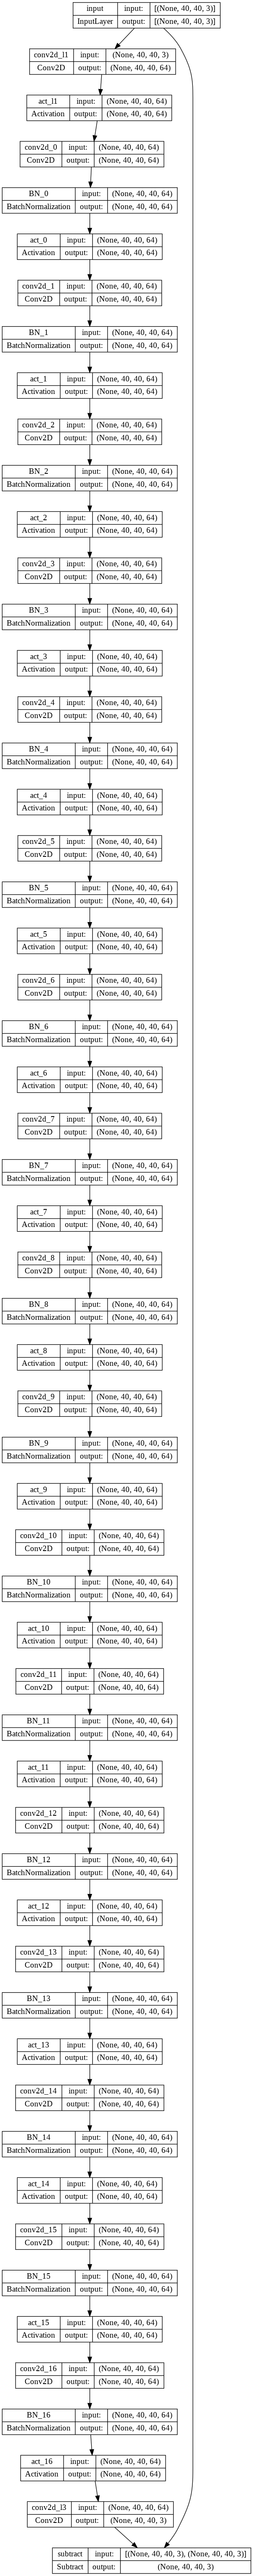

In [13]:
plot_model(dncnn,show_shapes=True,to_file='dncnn.png')

In [14]:
def scheduler(epoch,lr):
  return lr*0.95

In [15]:
checkpoint_path = "/content/drive/MyDrive/DataScience/dncnn.h5" 
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=False,verbose=0,save_best_only=False) 

# Tensorbaord 
logdir = os.path.join("/content/drive/MyDrive/DataScience/logs_dncnn", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) 
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [cp_callback,tensorboard_callback,lrScheduler]
dncnn.fit( train_dataset,shuffle=True,epochs=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 1/10
273/273 [==============================] - 7888s 29s/step - loss: 0.0128 - val_loss: 0.0033 - lr: 9.5000e-04
Epoch 2/10
273/273 [==============================] - 42s 155ms/step - loss: 0.0034 - val_loss: 0.0040 - lr: 9.0250e-04
Epoch 3/10
273/273 [==============================] - 42s 155ms/step - loss: 0.0033 - val_loss: 0.0046 - lr: 8.5737e-04
Epoch 4/10
273/273 [==============================] - 43s 156ms/step - loss: 0.0033 - val_loss: 0.0041 - lr: 8.1451e-04
Epoch 5/10
273/273 [==============================] - 44s 161ms/step - loss: 0.0031 - val_loss: 0.0031 - lr: 7.7378e-04
Epoch 6/10
273/273 [==============================] - 43s 158ms/step - loss: 0.0028 - val_loss: 0.0030 - lr: 7.3509e-04
Epoch 7/10
273/273 [==============================] - 43s 157ms/step - loss: 0.0025 - val_loss: 0.0029 - lr: 6.9834e-04
Epoch 8/10
273/273 [==============================] - 43s 158ms/step - loss: 0.0022 - val_loss: 0.0025 - lr: 6.6342e-04
Epoch 9/10
273/273 [====================

In [16]:
dncnn.fit( train_dataset,shuffle=True,epochs=30,initial_epoch=10,validation_data= test_dataset,callbacks=callbacks)

Epoch 11/30
273/273 [==============================] - 42s 155ms/step - loss: 0.0016 - val_loss: 0.0019 - lr: 5.6880e-04
Epoch 12/30
273/273 [==============================] - 42s 155ms/step - loss: 0.0016 - val_loss: 0.0027 - lr: 5.4036e-04
Epoch 13/30
273/273 [==============================] - 43s 156ms/step - loss: 0.0015 - val_loss: 0.0026 - lr: 5.1334e-04
Epoch 14/30
273/273 [==============================] - 43s 156ms/step - loss: 0.0015 - val_loss: 0.0030 - lr: 4.8767e-04
Epoch 15/30
273/273 [==============================] - 43s 157ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 4.6329e-04
Epoch 16/30
273/273 [==============================] - 43s 157ms/step - loss: 0.0015 - val_loss: 0.0014 - lr: 4.4013e-04
Epoch 17/30
273/273 [==============================] - 43s 157ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 4.1812e-04
Epoch 18/30
273/273 [==============================] - 43s 157ms/step - loss: 0.0014 - val_loss: 0.0015 - lr: 3.9721e-04
Epoch 19/30
273/273 [===========

In [ ]:
cp -r /content/logs_dncnn /content/drive/MyDrive/DataScience/

3/3 [==============================] - 1s 16ms/step
PSNR of Noisy Image :  20.801888234272848
PSNR of Denoised Image :  24.661752107078758


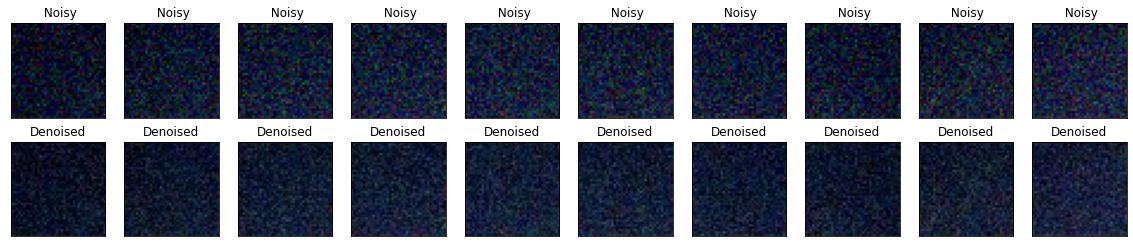

In [18]:
patches_noisy,denoised_patches,ground_truth,noisy_image,denoised_image=predict_fun(dncnn,'/content/drive/MyDrive/DataScience/test/384089.jpg',noise_level=25)
print('PSNR of Noisy Image : ',PSNR(ground_truth,noisy_image))
print('PSNR of Denoised Image : ',PSNR(ground_truth,denoised_image))
plot_patches(patches_noisy,denoised_patches)

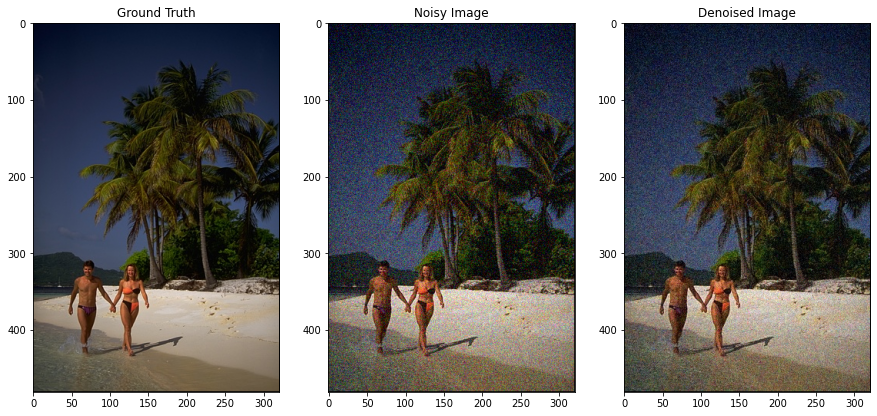

In [19]:
plot_predictions(ground_truth,noisy_image,denoised_image)

In [ ]:
layer_name = 'conv2d_l3' # Getting the output from the model just before subtract layer, Thus it gives the resiudues learnt
dncnn_res= Model(inputs=dncnn.input, outputs=dncnn.get_layer(layer_name).output) # Creating the model that gives the residual image output for the given noisy image

In [ ]:
patches_noisy,denoised_patches,ground_truth,noisy_image,residual_image=predict_fun(dncnn_res,'/content/drive/MyDrive/DataScience/test/102061.jpg',noise_level=25)
fig, axs = plt.subplots(1,2,figsize=(10,10))
axs[0].imshow(noisy_image)
axs[0].title.set_text('Noisy Image')
axs[1].imshow(residual_image)
axs[1].title.set_text('Residual Image')